# Detekcja krawędzi

## Cel ćwiczenia

- Zapoznanie z metodami detekcji krawędzi:
    - Sobel, Prewitt, Roberts - przypomnienie,
    - Laplasjan z Gaussa (LoG – ang. Laplacian of Gaussian),
    - Canny.

Detekcja krawędzi przez wiele lat była podstawą algorytmów segmentacji.
Krawędzie wykrywane są najczęściej z wykorzystaniem pierwszej (gradient) i drugiej (Laplasjan) pochodnej przestrzennej.
Wykorzystanie obu metod zaprezentowane zostało w ćwiczeniu *Przetwarzanie wstępne. Filtracja kontekstowa*.

W niniejszym ćwiczeniu poznane detektory krawędzi zostaną porównane z bardziej zaawansowanymi: Laplasjan z funkcji Gaussa (LoG), Zero Crossing i Canny.

## Laplasjan z Gaussa (LoG)

Funkcja Gaussa:<br>
\begin{equation}
h(r) = e^{\frac{-r^2}{2 \sigma^2}}
\end{equation}<br>
gdzie:
- $r^2 = x^2 + y^2$
- $\sigma$ to odchylenie standardowe.

Działanie filtracji Gaussowskiej zostało przedstawione w ćwiczeniu "Przetwarzanie wstępne". W jej wyniku następuje rozmazanie obrazu.
Laplasjan tej funkcji dany jest wzorem:

\begin{equation}
\nabla^2 h(r) = \frac{r^2 - 2\sigma^2}{\sigma^4} e^{-\frac{r^2}{2\sigma^2}}
\end{equation}

Funkcję (z oczywistych powodów) nazywamy Laplasjan z Gaussa (LoG).
Ponieważ druga pochodna jest operacją liniową, konwolucja obrazu z $\nabla^2 h(r)$ daje taki sam efekt jak zastosowanie filtracji Gaussa na obrazie, a następnie obliczenie Laplasjanu z wyniku.
Lokalizacja krawędzi polega na znalezieniu miejsca, gdzie po filtracji LoG następuje zmiana znaku.

In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import math
import os

if not os.path.exists("dom.png") :
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/09_Canny/dom.png --no-check-certificat

In [2]:
def show(image):
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

1. Wczytaj obraz *house.png*.

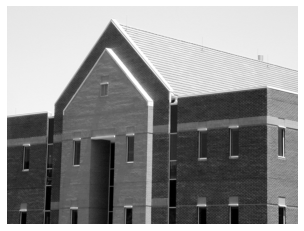

In [3]:
house = cv2.cvtColor(cv2.imread('dom.png'), cv2.COLOR_BGR2GRAY)
show(house)

2. Wykonaj rozmycie Gaussowskie obrazu wejściowego.
W tym celu wykorzysaj funkcję `cv2.GaussianBlur(img, kSize, sigma)`.
Pierwszy argument jest obrazem wejśćiowym.
Drugi jest rozmiarem filtru (podanym w nawiasach okrągłych, np. *(3, 3)*).
Trzecim argumentem jest odchylenie standardowe. Wartość jest dobrana automatycznie, jeśli zosanie podana wartość `0` (będą równe rozmiarowi).

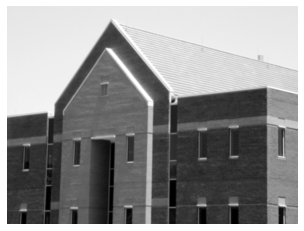

In [4]:
blurred = cv2.GaussianBlur(house, (3, 3), 0)
show(blurred)

3. Oblicz laplasjan obrazu rozmytego.
W tym celu wykorzysaj funkcję `cv2.Laplacian(img, ddepth)`.
Pierszym argumentem jest obraz wejściowy.
Drugim argumentem jest typ danych wejściowych. Użyj `cv2.CV_32F`.

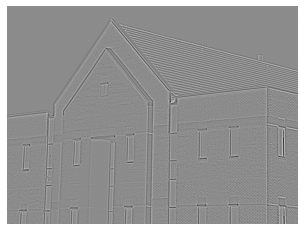

In [5]:
laplace = cv2.Laplacian(blurred, cv2.CV_32F)
show(laplace)

4. Wyznacz miejsca zmiany znaku.
Zaimplementuj funkcję `crossing(LoG, thr)`:
    - Najpierw stwórz tablicę, do której zostanie zapisany wynik.
    Jej rozmiar jest taki sam jak przetwarzanego obrazu.
    - Następnie wykonaj pętle po obrazie (bez ramki jednopikselowej).
    W każdej iteracji stwórz otoczenie o rozmiarze $3 \times 3$.
    Dla otoczenia oblicz wartość maksymalną i minimalną.
    - Jeśli wartości te mają przeciwne znaki, to do danego miejsca tablicy przypisz wartość:
        - jeśli piksel wejściowy > 0, to dodaj do niego wartość bezwzględną minimum.
        - jeśli piksel wejściowy < 0, to do jego wartości bezwzględnej dodaj maksimum.
    - Zmień zakres wykonanej tablicy do $<0, 255>$.
    - Wykonaj progowanie tablicy. Próg jest argumentem wejściowym.
    - Przeskaluj dane binarne do wartości `[0, 255]`.
    - Wykonaj konwersję do typu *uint8*.
    - Wykonaj rozmycie medianowe wyniku.
    Wykorzystaj funkcję `cv2.medianBlur(img, kSize)`.
    Pierwszym argumentem jest obraz wejśćiowy, a drugim rozmiar filtra.
    - Zwróć wyznaczoną tablicę.

In [6]:
def crossing(laplace, threshold):
    result = np.zeros(laplace.shape, dtype='uint8')
    width, height = result.shape
    
    for x in range(1, width-1):
        for y in range(1, height-1):
            context = laplace[x-1:x+2, y-1:y+2]
            max_ = np.max(context)
            min_ = np.min(context)
            
            if max_*min_ < 0:
                if context[1, 1] > 0:
                    result[x, y] = context[1, 1] + abs(min_)
                elif context[1, 1] < 0:
                    result[x, y] = abs(context[1, 1]) + max_
    
    normalized = cv2.normalize(result, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    _, binarized = cv2.threshold(normalized, threshold, 255, cv2.THRESH_BINARY)
    binarized = (binarized*255).astype('uint8')
    
    median_blurred = cv2.medianBlur(binarized, 3)
    return median_blurred

5. Wyświetl obraz wynikowy.
6. Dobierz parametry (rozmiar filtru Gaussa, odchylenie standardowe, próg binaryzacji) tak, by widoczne były kontury domu, ale nie dachówki.

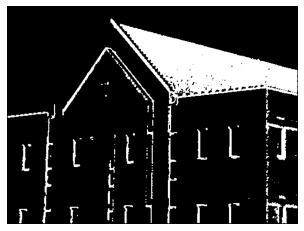

In [18]:
log_result = crossing(laplace, 60)
show(log_result)

## Algorytm Canny'ego

> Algorytm Canny'ego to często wykorzystywana metoda detekcji krawędzi.
> Zaproponowana została w 1986r. przez Johna F. Cannego.
> Przy jego projektowaniu założono trzy cele:
> - niska liczba błędów - algorytm powinien znajdywać wszystkie krawędzie oraz generować jak najmniej fałszywych detekcji,
> - punkty krawędziowe powinny być poprawnie lokalizowane - wykryte punkty powinny być jak najbardziej zbliżone do rzeczywistych,
> - krawędzie o szerokości 1 piksela - algorytm powinien zwrócić jeden punkt dla każdej rzeczywistej krawędzi.

Zaimplementuj algorytm detekcji krawędziCanny'ego:
1. W pierwszym kroku obraz przefiltruj dwuwymiarowym filtrem Gaussa.

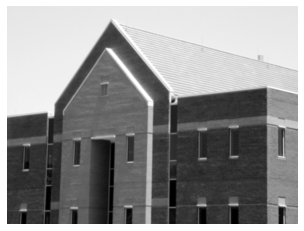

In [8]:
blurred = cv2.GaussianBlur(house, (3, 3), 0)
show(blurred)

2. Następnie oblicz gradient pionowy i poziomy ($g_x $ i $g_y$).
Jedną z metod jest filtracja Sobela.

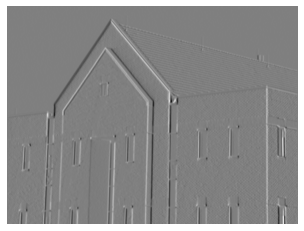

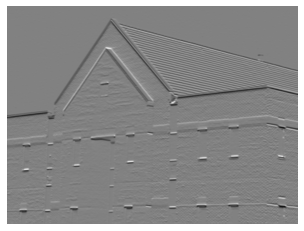

In [9]:
gx = cv2.Sobel(blurred, cv2.CV_32F, 1, 0)
gy = cv2.Sobel(blurred, cv2.CV_32F, 0, 1)

show(gx)
show(gy)

3. Dalej oblicz amplitudę:
$M(x,y)  = \sqrt{g_x^2+g_y^2}$ oraz kąt:
$\alpha(x,y) = arctan(\frac{g_y}{g_x})$.
Do obliczenia kąta wykorzystaj funkcję `np.arctan2(x1, x2)`.
Wynik jest w radianach.

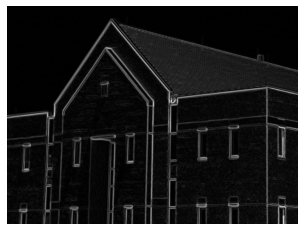

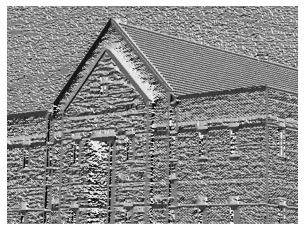

In [10]:
amplitude = np.sqrt(gx**2 + gy**2)
angle = np.arctan2(gy, gx)

show(amplitude)
show(angle)

4. W kolejnym etapie wykonaj kwantyzację kątów gradientu.
Kąty od $-180^\circ$ do $180^\circ$ można podzielić na 8 przedziałów:
[$-22.5^\circ, 22.5^\circ$], [$22.5^\circ, 67.5^\circ$],
[$67.5^\circ, 112.5^\circ$], [$112.5^\circ, 157.5^\circ$],
[$157.5^\circ, -157.5^\circ$], [$-157.5^\circ, -112.5^\circ$],
[$-112.5^\circ, -67.5^\circ$], [$-67.5^\circ, -22.5^\circ$].
Przy czym należy rozpatrywać tylko 4 kierunki:
    - pionowy ($d_1$),
    - poziomy ($d_2$),
    - skośny lewy ($d_3$),
    - skośny prawy ($d_4$).
    

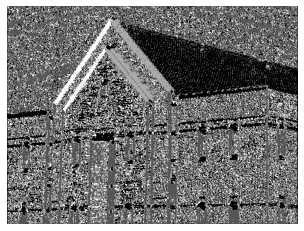

In [11]:
def quantize_angle(angle_radians):
    result = np.zeros(angle_radians.shape)
    width, height = result.shape
    
    for x in range(width):
        for y in range(height):
            angle = np.degrees(angle_radians[x, y])
            if -22.5 < angle < 22.5 or angle > 157.5 or angle < -157.5:
                result[x, y] = 2 # poziomy
            elif 22.5 <= angle <= 67.5 or -157.5 <= angle <= -112.5:
                result[x, y] = 4 # skośny prawy
            elif 112.5 <= angle <= 157.5 or -67.5 <= angle <= -22.5:
                result[x, y] = 3 # skośny lwey
            else:
                result[x, y] = 1 # pionowy
                
    return result

quantized_angles = quantize_angle(angle)
show(quantized_angles)

5. Dalej przeprowadź eliminację pikseli, które nie mają wartości maksymalnej (ang. *nonmaximal suppresion*).
Celem tej operacji jest redukcja szerokości krawędzi do rozmiaru 1 piksela.
Algorytm przebiega następująco.
W rozpatrywanym otoczeniu o rozmiarze $3 \times 3$:
    - określ do którego przedziału należy kierunek gradientu piksela centralnego ($d_1, d_2, d_3, d_4$).
    - przeanalizuje sąsiadów leżących na tym kierunku.
Jeśli choć jeden z nich ma amplitudę większą niż piksel centralny, to należy uznać, że nie jest lokalnym maksimum i do wyniku przypisać $g_N(x,y) = 0$.
W przeciwnym przypadku $g_N(x,y) = M(x,y)$.
Przez $g_N$ rozumiemy obraz detekcji lokalnych maksimów.
Zaimplementuj funkcję `nonmax`.
Pierwszym argementem jest macierz kierunków (po kwantyzacji).
Drugim argumentem jest macierz amplitudy.

In [12]:
def get_neighbor_ind(dir_, x, y):
    if dir_ == 1:
        return (x-1, y), (x+1, y)
    if dir_ == 2:
        return (x, y-1), (x, y-1)
    if dir_ == 3:
        return (x+1, y-1), (x-1, y+1)
    return (x-1, y-1), (x+1, y+1)

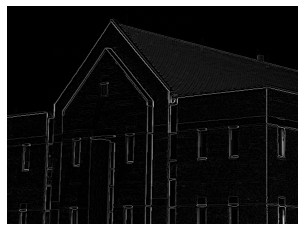

In [13]:
def nonmax(dirs, amplitude):
    g_n = np.zeros(dirs.shape)
    height, width = g_n.shape
    
    for x in range(height):
        for y in range(width):
            dir_ = dirs[x, y]
            (x1, y1), (x2, y2) = get_neighbor_ind(dir_, x, y)
            if height > x1 >= 0 and width > y1 >= 0 and amplitude[x1, y1] > amplitude[x, y]:
                continue
            if height > x2 >= 0 and width > y2 >= 0 and amplitude[x2, y2] > amplitude[x, y]:
                continue
            g_n[x, y] = amplitude[x, y]
        
    return g_n

g_n = nonmax(quantized_angles, amplitude)
show(g_n)

6. Ostatnią operacją jest binaryzacja obrazu $g_N$.
Stosuje się tutaj tzw. binaryzację z histerezą.
Wykorzystuje się w niej dwa progi: $T_L$ i $T_H$, przy czym $T_L < T_H$.
Canny zaproponował, aby stosunek progu wyższego do niższego był jak 3 lub 2 do 1.
Rezultaty binaryzacji można opisać jako:<br>
$g_{NH}(x,y) = g_N(x,y) \geq TH $<br>
$g_{NL}(x,y) = TH > g_N(x,y) \geq TL $<br>
Można powiedzieć, że na obrazie $g_{NH}$ są "pewne" krawędzie.
Natomiast na $g_{NL}$ "potencjalne".
Często krawędzie "pewne" nie są ciągłe.
Dlatego wykorzystuje się obraz $g_{NL}$ w następującej procedurze:
    - Stwórz stos zawierający wszystkie piksele zaznaczone na obrazie $g_{NH}$.
W tym celu wykorzystaj listę współrzędnych `[row, col]`.
Do pobrania elementu z początku służy metoda `list.pop()`.
Do dodania elementu na koniec listy służy metoda `list.append(new)`.
    - Stwórz obraz, który będzie zawierał informację czy dany piksel został już odwiedzony.
    - Stwórz obraz, któy zawierać będzie wynikowe krawędzie.
Jej rozmiar jest równy rozmiarowi obrazu.
    - Wykonaj pętlę, która będzie pobierać elementy z listy, dopóki ta nie będzie pusta.
W tym celu najlepiej sprawdzi się pętla `while`.
    - W każdej iteracji pobierz element ze stosu.
    - Sprawdź czy dany element został już odwiedzony.
    - Jeśli nie został, to:
        - Oznacz go jako odwiedzony,
        - Oznacz piksel jako krawędź w wyniku,
        - Sprawdź otoczenie piksela w obrazie $g_{NL}$,
        - Dodaj do stosu współrzędne otoczenia, które zawierają krawędź (potencjalną).
        Można to wykoanać np. pętlą po stworzonym otoczeniu.
        

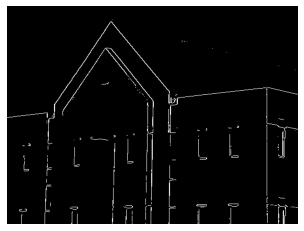

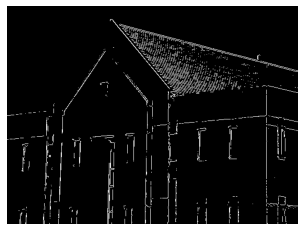

In [14]:
tl = 120
th = 240

g_nh = g_n >= th
g_nl = (g_n > tl) * (g_n <= th)

show(g_nh)
show(g_nl)

In [15]:
height, width = house.shape
stack = [(x, y) for x in range(height) for y in range(width) if g_nh[x, y]]

visited = np.zeros((height, width), dtype=bool)
edges = np.zeros((height, width), dtype=bool)

while stack:
    x, y = stack.pop()
    if not visited[x, y]:
        visited[x, y] = True
        edges[x, y] = True
        
        for neigh_x in range(x-1, x+2):
            for neigh_y in range(y-1, y+2):
                if height > neigh_x >= 0 and width > neigh_y >= 0:
                    if g_nl[neigh_x, neigh_y]:
                        stack.append((neigh_x, neigh_y))

7. Wyświetl obraz oryginalny, obraz $g_{NH}$ oraz obraz wynikowy.

Pomocnicze obrazy $g_{NH}$ i $g_{NL}$ zostały wprowadzone dla uproszczenia opisu.
Algorytm można zaimplementować wbardziej "zwarty" sposób.

Na podstawie powyższego opisu zaimplementuj algorytm Cannego.

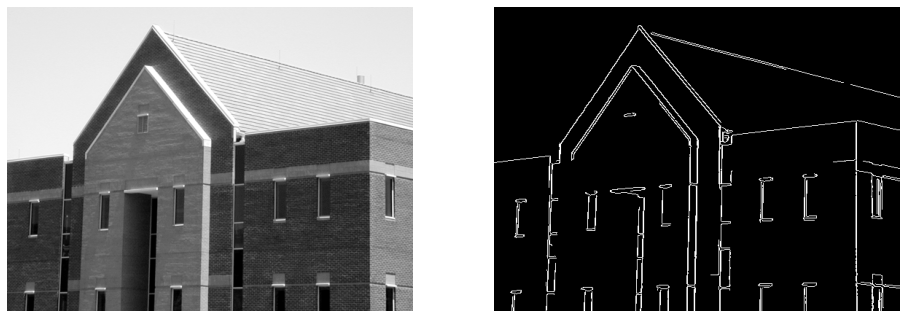

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

plt.gray()
ax[0].imshow(house)
ax[0].axis('off')

ax[1].imshow(edges)
ax[1].axis('off')

plt.show()

## Algorytm Canny'ego - OpenCV

1. Wykonaj dektekcję krawędzi metodą Canny'ego wykorzystując funkcję `cv2.Canny`.
    - Pierwszym argumentem funkcji jest obraz wejściowy.
    - Drugim argumentem jest mniejszy próg.
    - Trzecim argumentem jest większy próg.
    - Czwarty argument to tablica, do której wpisany zostanie wynik.
    Można zwrócić go przez wartość i podać wartość `None`.
    - Piąty argument to rozmiar operatora Sobela (w naszym przypadku 3).
    - Szósty argument to rodzaj używanej normy.
    0 oznacza normę $L_1$, 1 oznacza normę $L_2$. Użyj $L_2$.
2. Wynik wyświetl i porównaj z własną implementacją.

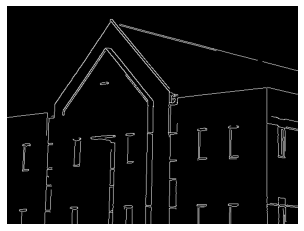

In [19]:
canny_lib_result = cv2.Canny(blurred, 120, 240, None, 3, 1)

plt.imshow(canny_lib_result)
plt.axis('off')
plt.show()